<a href="https://colab.research.google.com/github/yaedin/niy_certification/blob/main/Regression_Flight_delays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and read in Dataset

In [77]:
# Import the necessary libraries and load in the dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
import numpy as np

#read in data
df_jan2019 = pd.read_csv('https://niy-certification.s3.eu-central-1.amazonaws.com/usdot/Jan_2019_usdot.csv')

# Describe Dataset (no EDA - done in different Notebook)

In [80]:
# finding out some infos on columns
df_jan2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638649 entries, 0 to 638648
Data columns (total 55 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   YEAR                   638649 non-null  int64  
 1   MONTH                  638649 non-null  int64  
 2   DAY_OF_MONTH           638649 non-null  int64  
 3   DAY_OF_WEEK            638649 non-null  int64  
 4   FL_DATE                638649 non-null  object 
 5   OP_UNIQUE_CARRIER      638649 non-null  object 
 6   OP_CARRIER_AIRLINE_ID  638649 non-null  int64  
 7   OP_CARRIER             638649 non-null  object 
 8   TAIL_NUM               633964 non-null  object 
 9   OP_CARRIER_FL_NUM      638649 non-null  int64  
 10  ORIGIN_AIRPORT_ID      638649 non-null  int64  
 11  ORIGIN_AIRPORT_SEQ_ID  638649 non-null  int64  
 12  ORIGIN_CITY_MARKET_ID  638649 non-null  int64  
 13  ORIGIN                 638649 non-null  object 
 14  ORIGIN_CITY_NAME       638649 non-nu

In [81]:
#define object cols to drop later on
objectlist = list(df_jan2019.select_dtypes(include=['object']).columns)
print(objectlist)

['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER', 'TAIL_NUM', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM', 'DEP_TIME_BLK', 'ARR_TIME_BLK']


In [82]:
# to check if the drop worked out
df_jan2019.shape

(638649, 55)

In [84]:
#drop cols and check if 
df_jan2019_test = df_jan2019.drop(objectlist, axis=1)
df_jan2019_test.shape

(638649, 41)

In [85]:
#show some more information for each column
def my_info(df):
  info = pd.DataFrame(df.count(), columns=["filled"])
  info["filled %"] = round(info["filled"] / len(df), 4) * 100
  info["nunique"] = df.nunique()
  info["dtypes"] = df.dtypes
  info["uniques"] = np.nan
  for idx, row in info.iterrows():
    info.loc[idx, "uniques"] = str(list(df[idx].unique()))
  return info


my_info(df_jan2019_test)

,filled,filled %,nunique,dtypes,uniques
YEAR,638649,100.00,1,int64,[2019]
MONTH,638649,100.00,1,int64,[1]
DAY_OF_MONTH,638649,100.00,31,int64,"[11, 12, 13, 8, 9, 15, 16, 21, 22, 23, 24, 25,..."
DAY_OF_WEEK,638649,100.00,7,int64,"[5, 6, 7, 2, 3, 1, 4]"
OP_CARRIER_AIRLINE_ID,638649,100.00,26,int64,"[19393, 20397, 20409, 20416, 20304, 19805, 203..."
OP_CARRIER_FL_NUM,638649,100.00,6880,int64,"[1480, 2199, 402, 458, 1966, 103, 179, 2191, 1..."
ORIGIN_AIRPORT_ID,638649,100.00,360,int64,"[13204, 13232, 13244, 13296, 13342, 13487, 134..."
ORIGIN_AIRPORT_SEQ_ID,638649,100.00,360,int64,"[1320402, 1323202, 1324402, 1329604, 1334207, ..."
ORIGIN_CITY_MARKET_ID,638649,100.00,336,int64,"[31454, 30977, 33244, 30721, 33342, 31650, 334..."
ORIGIN_STATE_FIPS,638649,100.00,52,int64,"[12, 17, 47, 33, 55, 27, 22, 6, 40, 31, 51, 41..."


In [87]:
#dropping columns les than 20% filled columns
df_jan2019_test.drop(['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 54'], axis=1, inplace = True)
df_jan2019_test.shape

(638649, 35)

In [91]:
# drop nan valued rows
df_jan2019_test = df_jan2019_test.dropna()
df_jan2019_test.shape

(617649, 35)

In [90]:
my_info(df_jan2019_test)

,filled,filled %,nunique,dtypes,uniques
YEAR,617649,100.0,1,int64,[2019]
MONTH,617649,100.0,1,int64,[1]
DAY_OF_MONTH,617649,100.0,31,int64,"[11, 12, 13, 8, 9, 15, 16, 21, 22, 23, 24, 25,..."
DAY_OF_WEEK,617649,100.0,7,int64,"[5, 6, 7, 2, 3, 1, 4]"
OP_CARRIER_AIRLINE_ID,617649,100.0,26,int64,"[19393, 20397, 20409, 20416, 20304, 19805, 203..."
OP_CARRIER_FL_NUM,617649,100.0,6874,int64,"[1480, 2199, 402, 458, 1966, 103, 179, 2191, 1..."
ORIGIN_AIRPORT_ID,617649,100.0,360,int64,"[13204, 13232, 13244, 13296, 13342, 13487, 134..."
ORIGIN_AIRPORT_SEQ_ID,617649,100.0,360,int64,"[1320402, 1323202, 1324402, 1329604, 1334207, ..."
ORIGIN_CITY_MARKET_ID,617649,100.0,336,int64,"[31454, 30977, 33244, 30721, 33342, 31650, 334..."
ORIGIN_STATE_FIPS,617649,100.0,52,int64,"[12, 17, 47, 33, 55, 27, 22, 6, 40, 31, 51, 41..."


# Regression - XGBoost without dtype object

In [41]:
# Split into train and test splits using the random state of 42 and a test size of 20%

X = df_jan2019_test.drop('ARR_DELAY', axis=1)
y = df_jan2019_test['ARR_DELAY']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [42]:
# Create the XGBoost Regressor
xg_reg = xgb.XGBRegressor()

# Fit the Regressor
xg_reg.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = xg_reg.predict(X_test)

# Print r2_score
r2_xgb = r2_score(y_test, y_pred)
r2_xgb

[14:38:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9941283768766869

In [47]:
d = {'Model and feature': ['XGB without dtype object cols'], 'r2_score model': [r2_xgb], 'r2score_w_Hyperparameter': [0]}
df = pd.DataFrame(data=d)
df

,Model and feature,r2_score model,r2score_w_Hyperparameter
0,XGB without dtype object cols,0.994128,0


# Regression - XGBoost taking out relevant cols with arr delay dependancy

In [48]:
my_info(df_jan2019_test)

,filled,filled %,nunique,dtypes,uniques
YEAR,617649,100.0,1,int64,[2019]
MONTH,617649,100.0,1,int64,[1]
DAY_OF_MONTH,617649,100.0,31,int64,"[11, 12, 13, 8, 9, 15, 16, 21, 22, 23, 24, 25,..."
DAY_OF_WEEK,617649,100.0,7,int64,"[5, 6, 7, 2, 3, 1, 4]"
OP_CARRIER_AIRLINE_ID,617649,100.0,26,int64,"[19393, 20397, 20409, 20416, 20304, 19805, 203..."
OP_CARRIER_FL_NUM,617649,100.0,6874,int64,"[1480, 2199, 402, 458, 1966, 103, 179, 2191, 1..."
ORIGIN_AIRPORT_ID,617649,100.0,360,int64,"[13204, 13232, 13244, 13296, 13342, 13487, 134..."
ORIGIN_AIRPORT_SEQ_ID,617649,100.0,360,int64,"[1320402, 1323202, 1324402, 1329604, 1334207, ..."
ORIGIN_CITY_MARKET_ID,617649,100.0,336,int64,"[31454, 30977, 33244, 30721, 33342, 31650, 334..."
ORIGIN_STATE_FIPS,617649,100.0,52,int64,"[12, 17, 47, 33, 55, 27, 22, 6, 40, 31, 51, 41..."


In [49]:
#taking out columns which has direct implication to delay
df_jan2019_test.drop(['ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP'], axis=1, inplace = True)
len(df_jan2019_test.columns)

32

In [51]:
# Split into train and test splits using the random state of 42 and a test size of 20%

X = df_jan2019_test.drop('ARR_DELAY', axis=1)
y = df_jan2019_test['ARR_DELAY']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Create the XGBoost Regressor
xg_reg = xgb.XGBRegressor()

# Fit the Regressor
xg_reg.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = xg_reg.predict(X_test)

# Print r2_score
r2_xgb = r2_score(y_test, y_pred)
r2_xgb

[14:54:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9808004353329887

In [55]:
d = {'Model and feature': ['XGB + ARR related cols drop'], 'r2_score model': [r2_xgb], 'r2score_w_Hyperparameter': [0]}
df2 = pd.DataFrame(data=d)
df = df.append(df2)
df

,Model and feature,r2_score model,r2score_w_Hyperparameter
0,XGB without dtype object cols,0.994128,0
0,XGB + ARR related cols drop,0.980800,0


# Regression - XGBoost Taking out more cols with expectation of label relation

In [56]:
my_info(df_jan2019_test)

,filled,filled %,nunique,dtypes,uniques
YEAR,617649,100.0,1,int64,[2019]
MONTH,617649,100.0,1,int64,[1]
DAY_OF_MONTH,617649,100.0,31,int64,"[11, 12, 13, 8, 9, 15, 16, 21, 22, 23, 24, 25,..."
DAY_OF_WEEK,617649,100.0,7,int64,"[5, 6, 7, 2, 3, 1, 4]"
OP_CARRIER_AIRLINE_ID,617649,100.0,26,int64,"[19393, 20397, 20409, 20416, 20304, 19805, 203..."
OP_CARRIER_FL_NUM,617649,100.0,6874,int64,"[1480, 2199, 402, 458, 1966, 103, 179, 2191, 1..."
ORIGIN_AIRPORT_ID,617649,100.0,360,int64,"[13204, 13232, 13244, 13296, 13342, 13487, 134..."
ORIGIN_AIRPORT_SEQ_ID,617649,100.0,360,int64,"[1320402, 1323202, 1324402, 1329604, 1334207, ..."
ORIGIN_CITY_MARKET_ID,617649,100.0,336,int64,"[31454, 30977, 33244, 30721, 33342, 31650, 334..."
ORIGIN_STATE_FIPS,617649,100.0,52,int64,"[12, 17, 47, 33, 55, 27, 22, 6, 40, 31, 51, 41..."


In [57]:
#taking out columns which has direct implication to delay
df_jan2019_test.drop(['DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'WHEELS_OFF', 'WHEELS_ON'], axis=1, inplace = True)
len(df_jan2019_test.columns)

26

In [58]:
# Split into train and test splits using the random state of 42 and a test size of 20%

X = df_jan2019_test.drop('ARR_DELAY', axis=1)
y = df_jan2019_test['ARR_DELAY']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Create the XGBoost Regressor
xg_reg = xgb.XGBRegressor()

# Fit the Regressor
xg_reg.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = xg_reg.predict(X_test)

# Print r2_score
r2_xgb = r2_score(y_test, y_pred)
r2_xgb

[15:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8011917290635191

In [59]:
d = {'Model and feature': ['XGB + DEP related cols drop'], 'r2_score model': [r2_xgb], 'r2score_w_Hyperparameter': [0]}
df2 = pd.DataFrame(data=d)
df = df.append(df2)
df

,Model and feature,r2_score model,r2score_w_Hyperparameter
0,XGB without dtype object cols,0.994128,0
0,XGB + ARR related cols drop,0.980800,0
0,XGB + DEP related cols drop,0.801192,0


# Try to find out some more feature which has strong relationship to label

In [60]:
my_info(df_jan2019_test)

,filled,filled %,nunique,dtypes,uniques
YEAR,617649,100.0,1,int64,[2019]
MONTH,617649,100.0,1,int64,[1]
DAY_OF_MONTH,617649,100.0,31,int64,"[11, 12, 13, 8, 9, 15, 16, 21, 22, 23, 24, 25,..."
DAY_OF_WEEK,617649,100.0,7,int64,"[5, 6, 7, 2, 3, 1, 4]"
OP_CARRIER_AIRLINE_ID,617649,100.0,26,int64,"[19393, 20397, 20409, 20416, 20304, 19805, 203..."
OP_CARRIER_FL_NUM,617649,100.0,6874,int64,"[1480, 2199, 402, 458, 1966, 103, 179, 2191, 1..."
ORIGIN_AIRPORT_ID,617649,100.0,360,int64,"[13204, 13232, 13244, 13296, 13342, 13487, 134..."
ORIGIN_AIRPORT_SEQ_ID,617649,100.0,360,int64,"[1320402, 1323202, 1324402, 1329604, 1334207, ..."
ORIGIN_CITY_MARKET_ID,617649,100.0,336,int64,"[31454, 30977, 33244, 30721, 33342, 31650, 334..."
ORIGIN_STATE_FIPS,617649,100.0,52,int64,"[12, 17, 47, 33, 55, 27, 22, 6, 40, 31, 51, 41..."


# Regression Comparison
Now, using matplotlib, plot the $R^2$ scores.

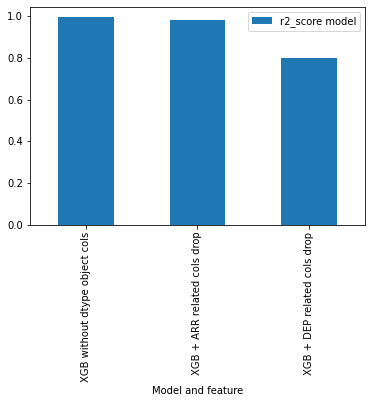

In [75]:
# INSERT CODE HERE
df['r2_score model'].astype(float)
df.plot(x= 'Model and feature', y = 'r2_score model', kind = 'bar')

# Main Takeaways


1.   Took new Dataset from https://www.transtats.bts.gov/Databases.asp?Mode_ID=1&Mode_DESC=Aviation&Subject_ID2=3
2.   Made an XGboost on whole dataset with some basic cleaning -> Strong Score as other columns with delay information are avaiable
3.   After taking out arrivel delay related columns, no strong implication as departure delay show high dependancy
4.   Taking out departure delay information leeds to massive decline of r2 score


